# Automatización de Osciloscopio Instek para el calculo de impedancia

Primero importamos librerias y reseteamos variables (por si ejecutamos repetidas veces el mismo notebook).

Antes de ejecutar el notebook debemos setear el puerto serie para que nos permita leerlo, desde un termina hacemos:

sudo chmod 777 /dev/ttyACM0                                       


In [1]:
# Reset de variables
%reset
# Instrucción para el notebook, hace los ploteos dentro del notebook
%matplotlib inline

# Paquete pyserial
import serial
# Paquete time
import time
# Paquete numpy, para operaciones con vectores y matrices
import numpy as np
# Paquete para plotear al estilo Matlab
import matplotlib.pyplot as plt




Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Armamos una función que toma la lectura cruda de un canal y nos devuelve el dato

In [26]:
def Parsear_canal(memoria_canal, offset, scale, muestras, VERBOSE):
    if VERBOSE:
        print('Header en buffer:')
        print(memoria_canal_1[0:14])
    
    # Leemos el "#4", el comienzo del header de los datos
    # un char (int 8 bits) litle-endian
    h  = np.frombuffer(memoria_canal, dtype=np.int8, count=1, offset=0)
    f  = np.frombuffer(memoria_canal, dtype=np.int8, count=1, offset=1)

    # Leemos el resto del header, tamaño de los datos
    nn  = np.frombuffer(memoria_canal, dtype=np.int8, count=4, offset=2)

    # Leemos la base de tiempo
    tb = np.frombuffer(memoria_canal, dtype=np.uint8, count=4, offset=6) 
    # Viene en big-endian (IEEE 754), convertimos a little-endian (revertimos el orden de los bytes)
    t = tb.newbyteorder()

    # Leemos el numero de canal del que proviene (dado antes por "ACQ#:")
    ch = np.frombuffer(memoria_canal, dtype=np.int8, count=1, offset=10)

    # Sacamos del buffer los 3 bytes reservados
    r = np.frombuffer(memoria_canal, dtype=np.int8, count=3, offset=11)
    
    if VERBOSE:
        print("Header decodificado:")
        print(str(chr(h)), str(chr(f)), str(chr(nn[0])), str(chr(nn[1])), str(chr(nn[2])), str(chr(nn[3])), t, ch)

    # Ahora convertimos los valores del ADC a volts
    #   is ADCgain the ADC mapping of 10 volts range onto 256 8-bit values
    #   ... or is it really just a magic constant of 1/25?
    ADCgain = 10.0/250;  #todo: why not 256?  data matches for 1/25

    # Leemos 4000 cuentas crudas del ADC
    # Valores de 16 bits signados, pero el LSB es siempre 0, siendo realmente
    # valores de 8 bits
    memoria_np_canal = np.frombuffer(memoria_canal, dtype=np.int16, count=muestras, offset=14)
    memoria_np_canal = memoria_np_canal/(2**8)

    v = offset + memoria_np_canal*scale*ADCgain;

    if VERBOSE:
        print(memoria_np_canal.shape)
        print(memoria_np_canal)

    return v


## Seteo el puerto serie

In [27]:

ser = serial.Serial(
    port='/dev/ttyACM0',
    baudrate=115200,
    timeout=10
#    parity=serial.PARITY_ODD,
#    stopbits=serial.STOPBITS_ONE,
#    bytesize=serial.EIGHTBITS
)

print("Puerto usado: %s"%ser.name)

# Pregunto al osciloscio su modelo
ser.write("*IDN?\n".encode())     
# Espero la respuesta
time.sleep(1)
while ser.in_waiting: 
    print (ser.readline())
    


Puerto usado: /dev/ttyACM0
b'GW,GDS-1102A-U,GEO211062,V1.14\n'


## Pedimos los datos del canal 1:

Canal 1:
Escala:  1.0
Offset:  0.04
Base de tiempo:  0.001
Leidos 4095 datos


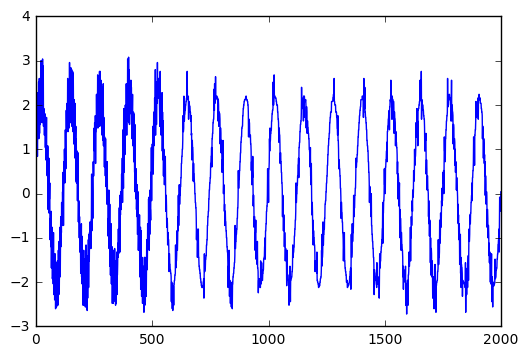

In [28]:
print("Canal 1:")

# Apagamos el modo actual de adquisicion (generalmente triggered) y lo
# pasamos a "single"
ser.write(":STOP\n".encode()) 
time.sleep(1.0);
ser.write(":SINGLE\n".encode()) 
time.sleep(1.0);

# Pedimos la escala (volt/div)
ser.reset_input_buffer()
ser.write(":CHAN1:SCAL?\n".encode()) 
time.sleep(1.0);
while ser.in_waiting:  # Or: while ser.inWaiting():
    scale_1_buff  = ser.readline();
scale_1 = float(scale_1_buff)
print("Escala: ",scale_1)

# Pedimos el offset de la señal
ser.reset_input_buffer()
ser.write(":CHAN1:OFFS?\n".encode()) 
time.sleep(1.0);
while ser.in_waiting:  # Or: while ser.inWaiting():
    offset_1_buff = ser.readline();
offset_1 = float(offset_1_buff)
print("Offset: ",offset_1)

# Pedimos la escala de tiempo de la señal
ser.reset_input_buffer()
ser.write(":timebase:scale?\n".encode()) 
time.sleep(1.0);
while ser.in_waiting:  # Or: while ser.inWaiting():
    time_1_buff = ser.readline();
time_1 = float(time_1_buff)
print("Base de tiempo: ",time_1)




# Leemos canal 1
ser.write(":ACQ1:MEM?\n".encode()) 
#ser.write(":ACQUIRE1:LMEMORY?\n".encode()) 
time.sleep(2.0);
n = ser.inWaiting()
memoria_canal_1 = ser.read(n)
print("Leidos %d datos"%n)
    
# Parseamos los datos
ch1 = Parsear_canal(memoria_canal_1, offset_1, scale_1, 2000, False)
    
# Mostramos
plt.plot(ch1)

## Pedimos los datos del canal 2:

Canal 2:
Escala:  0.5
Offset:  0.0
Base de tiempo:  0.001
Leidos 4095 datos


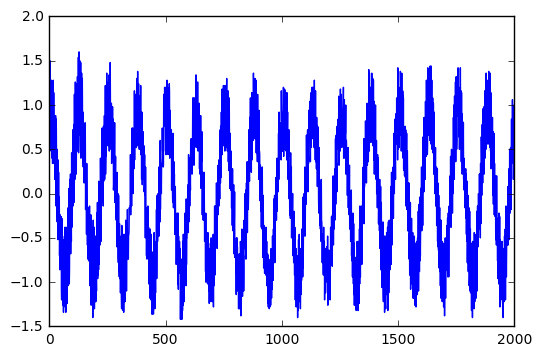

In [29]:
print("Canal 2:")

# Apagamos el modo actual de adquisicion (generalmente triggered) y lo
# pasamos a "single"
ser.write(":STOP\n".encode()) 
time.sleep(1.0);
ser.write(":SINGLE\n".encode()) 
time.sleep(1.0);

# Pedimos la escala (volt/div)
ser.reset_input_buffer()
ser.write(":CHAN2:SCAL?\n".encode()) 
time.sleep(1.0);
while ser.in_waiting:  # Or: while ser.inWaiting():
    scale_2_buff  = ser.readline();
scale_2 = float(scale_2_buff)
print("Escala: ",scale_2)

# Pedimos el offset de la señal
ser.reset_input_buffer()
ser.write(":CHAN2:OFFS?\n".encode()) 
time.sleep(1.0);
while ser.in_waiting:  # Or: while ser.inWaiting():
    offset_2_buff = ser.readline();
offset_2 = float(offset_2_buff)
print("Offset: ",offset_2)

# Pedimos la escala de tiempo de la señal
ser.reset_input_buffer()
ser.write(":timebase:scale?\n".encode()) 
time.sleep(1.0);
while ser.in_waiting:  # Or: while ser.inWaiting():
    time_2_buff = ser.readline();
time_2 = float(time_2_buff)
print("Base de tiempo: ",time_2)

# Leemos canal 1
ser.write(":ACQ2:MEM?\n".encode()) 
#ser.write(":ACQUIRE1:LMEMORY?\n".encode()) 
time.sleep(2.0);
n = ser.inWaiting()
memoria_canal_2 = ser.read(n)
print("Leidos %d datos"%n)

# Parseamos los datos
ch2 = Parsear_canal(memoria_canal_2, offset_2, scale_2, 2000, False)
    
# Mostramos
plt.plot(ch2)

## Finalmente cerramos el puerto, sino va a haber problemas...

In [30]:
ser.close()             # close port

## Calculo de Impedancia

Ahora sabiendo que el canal 1 es la tensión sobre el capacitor/inductor y que la diferencia entre ambos (conociendo la resistencia) es la corriente, podemos calcular el valor de la impedancia. 
Primero calculamos la señal de corriente y la transformada de fourier de ambas señales:

In [31]:
# Fs = 250
# f = 20
# sample = 1e5
# x = np.arange(sample)
# ch1 = 40*np.sin(2 * np.pi * f * x / Fs)


# x = np.arange(sample)
# ch2 = 10*np.sin(2 * np.pi * f * x / Fs + np.pi/6)

# plt.figure()
# plt.plot(sinal_1)
# plt.plot(sinal_2)




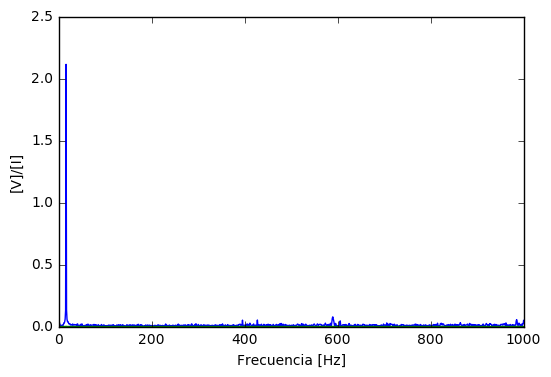

In [32]:
R = 1000
sample = 2000
Fs = 2000

# Señal de corriente
I_signal = (ch1-ch2)/R

# Transformo
V_fft = np.fft.fft(ch1)
V_fft = V_fft[0:np.floor(sample/2).astype(np.int)]
I_fft = np.fft.fft(I_signal)
I_fft = I_fft[0:np.floor(sample/2).astype(np.int)]

# Modulo
V_fft_abs= np.abs(V_fft)
V_fft_abs = V_fft_abs/len(V_fft_abs)
I_fft_abs = np.abs(I_fft)
I_fft_abs = I_fft_abs/len(I_fft_abs)

# Fase
V_fft_fase = np.angle(V_fft)
I_fft_fase = np.angle(I_fft)


# Calculo el eje de frecuencia
fcia=np.linspace(0,Fs/2,len(V_fft))

plt.figure()
plt.plot(fcia,V_fft_abs)
plt.plot(fcia,I_fft_abs)
plt.ylabel("[V]/[I]")
plt.xlabel("Frecuencia [Hz]")


In [31]:
#print(1/(time_1*10/2000))
#print(time_2)

In [33]:
# Busco el maximo
V_arg_max = np.argmax(V_fft_abs)
I_arg_max = np.argmax(I_fft_abs)

# Calculo el modulo de la impedancia
Z=V_fft_abs[V_arg_max]/I_fft_abs[I_arg_max]

# Y determino la frecuencia de la señal
f = fcia[V_arg_max]

# Recupero la fase en el punto, que es la fase de cada canal
V_fase = V_fft_fase[V_arg_max]
I_fase = I_fft_fase[I_arg_max]

# Calculo la diferencia de fase
diff_fase = (V_fase-I_fase)

# Descompongo la impedancia
Zreal=Z*np.cos(diff_fase)
Zim=Z*np.sin(diff_fase)

# informo
print("el modulo de la impedancia es {} ohm".format(Z))
print("la fase de Z es {} grados".format(np.rad2deg(diff_fase)))

print("parte real {} ohms".format(Zreal))
print("parte imaginaria {} ohms".format(Zim))

el modulo de la impedancia es 1185.8691920137157 ohm
la fase de Z es 26.119428531345633 grados
parte real 1064.766266742665 ohms
parte imaginaria 522.0713914534593 ohms


### Finalmente determino el elemento y calculo su valor

In [34]:
if Zim < 0:
    # Es un capacitor, lo despejo
    C=1/(np.abs(Zim)*2*np.pi*f)
    print("Capacitancia : {}".format(C))
else:
    # Es un inductor, lo despejo
    L=np.abs(Zim)/(2*np.pi*f)
    print("Inductancia : {}".format(L))

Inductancia : 5.187947022130328
